# Overview

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-1c company.

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from matplotlib import rcParams
from typing import List

import utils

# Load Data

In [2]:
train_df, test_df = utils.load_data()

In [3]:
train_df.shape

(2935849, 10)

In [4]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
49800,2013-01-01,0,18,5823,2500.0,1.0,Playstation Store пополнение бумажника: Карта ...,35,Карты оплаты - PSN,"Красноярск ТЦ ""Июнь"""
29784,2013-01-01,0,27,5573,849.0,1.0,PS Move Motion Controller Charger (Зарядная ст...,2,Аксессуары - PS3,"Москва ТЦ ""МЕГА Белая Дача II"""
35476,2013-01-01,0,7,1006,399.0,1.0,3D Crystal Puzzle Дельфин XL,67,Подарки - Развитие,"Воронеж ТРЦ ""Максимир"""
8330,2013-01-01,0,19,17707,899.0,1.0,Праздник спорта (Essentials) (только для PS Mo...,19,Игры - PS3,"Курск ТЦ ""Пушкинский"""
57384,2013-01-01,0,14,19548,149.0,1.0,ТАКИЕ РАЗНЫЕ БЛИЗНЕЦЫ (регион),40,Кино - DVD,"Казань ТЦ ""ПаркХаус"" II"


In [5]:
print(f"Starting date: {train_df['date'].min()}")
print(f"Ending date: {train_df['date'].max()}")
print(f"Number of months: {len(train_df['date_block_num'].unique())}")

Starting date: 2013-01-01 00:00:00
Ending date: 2015-10-31 00:00:00
Number of months: 34


November 2015 & December 2015 are missing.

In [6]:
print(f"Number of shops: {len(train_df['shop_id'].unique())}")
print(f"Number of items: {len(train_df['item_id'].unique())}")
print(f"Number of categories: {len(train_df['item_category_id'].unique())}")

Number of shops: 60
Number of items: 21807
Number of categories: 84


In [7]:
train_df[["item_price","item_cnt_day"]].describe() 

,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06
mean,8.908532e+02,1.242641e+00
std,1.729800e+03,2.618834e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


In [8]:
print("Are there any missing values?")
train_df.isna().sum()

Are there any missing values?


date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

We can see that the data is already cleaned.

In [9]:
test_df.shape

(214200, 8)

In [10]:
test_df.head()

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,item_cnt_month
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",NaN
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",NaN
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",NaN
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",NaN
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",NaN


In [11]:
print(f"Number of shops: {len(test_df['shop_id'].unique())}")
print(f"Number of items: {len(test_df['item_id'].unique())}")
print(f"Number of categories: {len(test_df['item_category_id'].unique())}")

Number of shops: 42
Number of items: 5100
Number of categories: 62


In [12]:
print("Are there any missing values?")
test_df.isna().sum()

Are there any missing values?


ID                         0
shop_id                    0
item_id                    0
item_name                  0
item_category_id           0
item_category_name         0
shop_name                  0
item_cnt_month        214200
dtype: int64

# Outliers

In [13]:
def detect_outliers(df: pd.DataFrame):
    df = df.copy()
    
    axes = None
    _, axes = plt.subplots(2,2, figsize=(10,5), constrained_layout=True)
    axes[0, 0].set_title("Before Removing Outliers (Prices)")
    axes[1, 0].set_title("Before Removing Outliers (Sales)")
    sns.boxplot(x=df["item_price"], ax=axes[0, 0])
    sns.boxplot(x=df["item_cnt_day"], ax=axes[1, 0])
    
    # Drop training items with extreme or negative prices or sales counts
    df = df[(df["item_price"] > 0) & (df["item_price"] < 50000)]
    df = df[(df["item_cnt_day"] > 0) & (df["item_cnt_day"] < 1000)]
    
    axes[0, 1].set_title("After Removing Outliers (Prices)")
    axes[1, 1].set_title("After Removing Outliers (Sales)")
    sns.boxplot(x=df["item_price"], ax=axes[0, 1])
    sns.boxplot(x=df["item_cnt_day"], ax=axes[1, 1])
    plt.show()

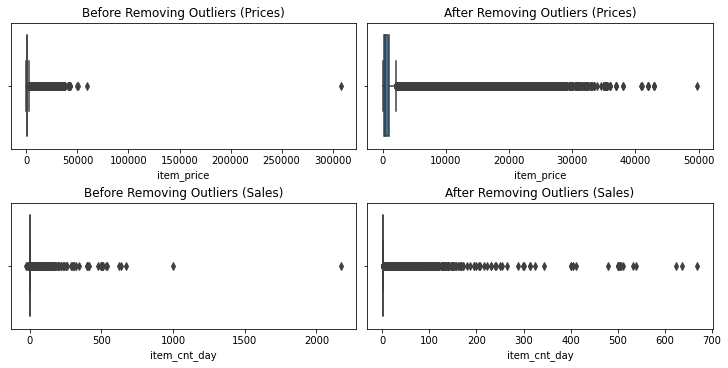

In [14]:
detect_outliers(train_df)

# Preprocess

## Detect Same Shops

In [15]:
def get_shop_name(df: pd.DataFrame, shop_id: int) -> str:
    row = df[df["shop_id"] == shop_id].iloc[0]
    
    return row["shop_name"]

In [16]:
print(get_shop_name(train_df, shop_id=0))
print(get_shop_name(train_df, shop_id=57))

!Якутск Орджоникидзе, 56 фран
Якутск Орджоникидзе, 56


In [17]:
print(get_shop_name(train_df, shop_id=1))
print(get_shop_name(train_df, shop_id=58))

!Якутск ТЦ "Центральный" фран
Якутск ТЦ "Центральный"


In [18]:
print(get_shop_name(train_df, shop_id=10))
print(get_shop_name(train_df, shop_id=11))

Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²


In [19]:
print(get_shop_name(train_df, shop_id=40))
print(get_shop_name(train_df, shop_id=39))

РостовНаДону ТРК "Мегацентр Горизонт" Островной
РостовНаДону ТРК "Мегацентр Горизонт"


### Replace shop_id

In [20]:
train_df["shop_id"] = train_df["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
test_df["shop_id"] = test_df["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

Let's see how many unique shops we have now:

In [21]:
print(f"Number of shops in train_split: {len(train_df['shop_id'].unique())} (before = 60)")
print(f"Number of shops in test_split: {len(test_df['shop_id'].unique())} (before = 42)")

Number of shops in train_split: 56 (before = 60)
Number of shops in test_split: 42 (before = 42)


We can observe that those shops were not even present in the test split.

## Add Revenue Features

In [22]:
train_df["item_revenue"] = train_df["item_cnt_day"] * train_df["item_price"]

## Aggregate Data into Months

In [23]:
train_monthly_df_group = train_df.groupby(["date_block_num", "shop_id", "item_category_id", "item_id"], as_index=False)
train_monthly_df = train_monthly_df_group.agg({"item_price": ["mean"], "item_cnt_day": ["sum", "mean", "count"], "item_revenue": ["sum"]})

In [24]:
train_monthly_df.head()

date_block_num shop_id item_category_id item_id   item_price item_cnt_day  \
                                                          mean          sum   
0              0       2                2    5572  1532.857143          9.0   
1              0       2                2    5573   924.000000          2.0   
2              0       2                2    5575   955.005000          4.0   
3              0       2                2    5576  2490.000000          3.0   
4              0       2                2    5632  2390.000000          1.0   

                  item_revenue  
       mean count          sum  
0  1.285714     7     13910.00  
1  1.000000     2      1848.00  
2  1.000000     4      3820.02  
3  1.000000     3      7470.00  
4  1.000000     1      2390.00

In [25]:
train_monthly_df.columns = ["month_block", "shop_id", "item_category_id", "item_id", "mean_item_price", "item_cnt", "mean_item_cnt_day", "transactions", "item_revenue"]
train_monthly_df.head()

,month_block,shop_id,item_category_id,item_id,mean_item_price,item_cnt,mean_item_cnt_day,transactions,item_revenue
0,0,2,2,5572,1532.857143,9.0,1.285714,7,13910.00
1,0,2,2,5573,924.000000,2.0,1.000000,2,1848.00
2,0,2,2,5575,955.005000,4.0,1.000000,4,3820.02
3,0,2,2,5576,2490.000000,3.0,1.000000,3,7470.00
4,0,2,2,5632,2390.000000,1.0,1.000000,1,2390.00


## Make Data Continuous

In [26]:
def fill_empty_months(df: pd.DataFrame) -> pd.DataFrame:
    month_ids = df["month_block"].unique()
    shop_ids = df["shop_id"].unique()
    item_ids = df["item_id"].unique()
    
    month_ids.sort()
    shop_ids.sort()
    item_ids.sort()
    
    # TODO: Speed up this for loops.
    empty_df = []
    for i in month_ids:
        for shop in shop_ids:
            for item in item_ids:
                empty_df.append([i, shop, item])
    empty_df = pd.DataFrame(empty_df, columns=["month_block","shop_id","item_id"])
    df = empty_df.merge(df, on=["month_block","shop_id","item_id"], how="left")
    df = df.fillna(0)
    
    return df

In [27]:
# TAKES TOO MUCH TIME.
# print(f"Number of records before making it continuous: {len(train_monthly_df)}")
# train_monthly_df = fill_empty_months(train_monthly_df)
# print(f"Number of records after making it continuous: {len(train_monthly_df)}")

## Add Time Features

In [28]:
train_monthly_df["year"] = train_monthly_df["month_block"].apply(lambda x: ((x//12) + 2013))
train_monthly_df["month"] = train_monthly_df["month_block"].apply(lambda x: (x % 12))

# EDA

# Company Level

## Sales for the Whole Company

Text(0, 0.5, 'Total Revenue')

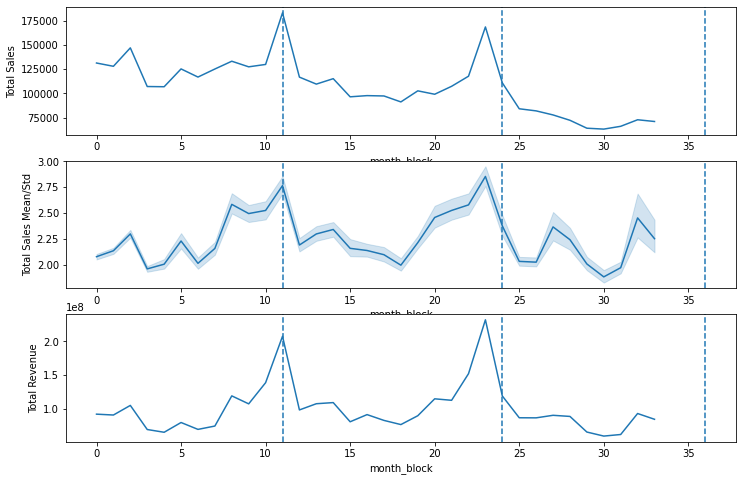

In [29]:
train_monthly_company_sales_df = train_monthly_df.groupby(["month_block"]).agg({"item_cnt": "sum", "item_revenue": "sum"})

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
sns.lineplot(x="month_block", y="item_cnt", data=train_monthly_company_sales_df, ax=ax[0])
ax[0].axvline(11, 0, 3, linestyle="--")
ax[0].axvline(24, 0, 3, linestyle="--")
ax[0].axvline(36, 0, 3, linestyle="--")
ax[0].set_ylabel("Total Sales")

sns.lineplot(x="month_block", y="item_cnt", data=train_monthly_df, ax=ax[1])
ax[1].axvline(11, 0, 3, linestyle="--")
ax[1].axvline(24, 0, 3, linestyle="--")
ax[1].axvline(36, 0, 3, linestyle="--")
ax[1].set_ylabel("Total Sales Mean/Std")

sns.lineplot(x="month_block", y="item_revenue", data=train_monthly_company_sales_df, ax=ax[2])
ax[2].axvline(11, 0, 3, linestyle="--")
ax[2].axvline(24, 0, 3, linestyle="--")
ax[2].axvline(36, 0, 3, linestyle="--")
ax[2].set_ylabel("Total Revenue")

## Sales for the Whole Company (Overlaid)

Text(0, 0.5, 'Total Revenue')

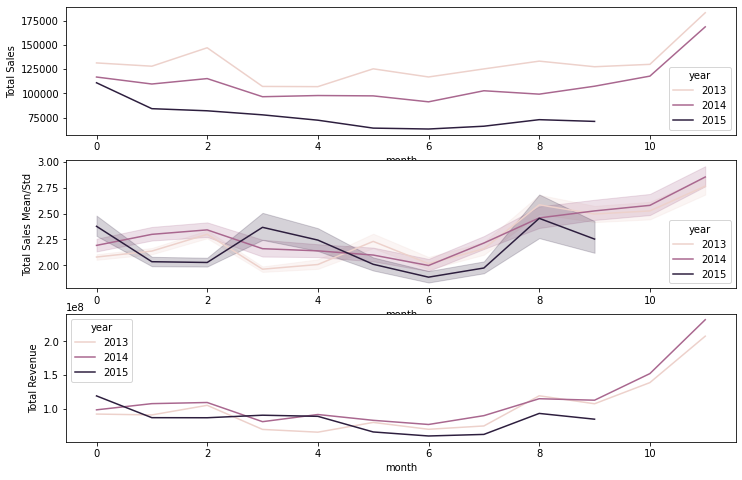

In [30]:
train_monthly_company_sales_df = train_monthly_df.groupby(["year", "month"]).agg({"item_cnt": "sum", "item_revenue": "sum"})
train_monthly_company_sales_df.head()

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
sns.lineplot(x="month", y="item_cnt", hue="year", data=train_monthly_company_sales_df, ax=ax[0])
ax[0].set_ylabel("Total Sales")

sns.lineplot(x="month", y="item_cnt", hue="year", data=train_monthly_df, ax=ax[1])
ax[1].set_ylabel("Total Sales Mean/Std")

sns.lineplot(x="month", y="item_revenue", hue="year", data=train_monthly_company_sales_df, ax=ax[2])
ax[2].set_ylabel("Total Revenue")

# City Level

# Category Level

## What Category Sales More ?

In [31]:
def fill_missing_categories(df: pd.DataFrame, all_possible_categories: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_categories = set(df["item_category_id"].unique())
    missing_categories = all_possible_categories - df_categories
    new_rows = []
    for missing_category_id in missing_categories:
        new_rows.append(
            (year, missing_category_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "item_category_id", "item_cnt"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [32]:
train_categories_sales_df = train_monthly_df.groupby(["year", "item_category_id"], as_index=False).agg({"item_cnt": ["sum"]})
train_categories_sales_df.columns = ["year", "item_category_id", "item_cnt"]

categories_year_2013 = train_categories_sales_df[train_categories_sales_df["year"] == 2013]
categories_year_2014 = train_categories_sales_df[train_categories_sales_df["year"] == 2014]
categories_year_2015 = train_categories_sales_df[train_categories_sales_df["year"] == 2015]

all_possible_categories = set(categories_year_2013["item_category_id"].unique()).union(set(categories_year_2014["item_category_id"].unique())).union(set(categories_year_2015["item_category_id"].unique()))
categories_year_2013 = fill_missing_categories(categories_year_2013, all_possible_categories)
categories_year_2014 = fill_missing_categories(categories_year_2014, all_possible_categories)
categories_year_2015 = fill_missing_categories(categories_year_2015, all_possible_categories)

[(0.0, 330990.0)]

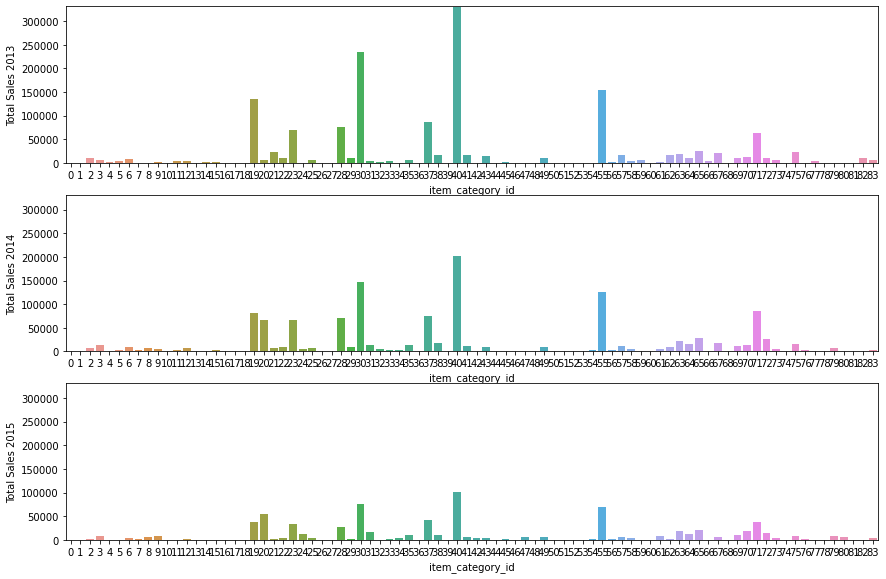

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2013, ax=ax[0])
ax[0].set_ylabel("Total Sales 2013")
ax[0].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))
sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2014, ax=ax[1])
ax[1].set_ylabel("Total Sales 2014")
ax[1].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))
sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2015, ax=ax[2])
ax[2].set_ylabel("Total Sales 2015")
ax[2].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))

# Number of Items / Category

In [34]:
def fill_missing_categories(df: pd.DataFrame, all_possible_categories: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_categories = set(df["item_category_id"].unique())
    missing_categories = all_possible_categories - df_categories
    new_rows = []
    for missing_category_id in missing_categories:
        new_rows.append(
            (year, missing_category_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "item_category_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [35]:
train_number_items_df = train_monthly_df.groupby(["year", "item_category_id"], as_index=False).agg({"item_id": ["count"]})
train_number_items_df.columns = ["year", "item_category_id", "num_items"]

categories_year_2013 = train_number_items_df[train_number_items_df["year"] == 2013]
categories_year_2014 = train_number_items_df[train_number_items_df["year"] == 2014]
categories_year_2015 = train_number_items_df[train_number_items_df["year"] == 2015]

all_possible_categories = set(categories_year_2013["item_category_id"].unique()).union(set(categories_year_2014["item_category_id"].unique())).union(set(categories_year_2015["item_category_id"].unique()))
categories_year_2013 = fill_missing_categories(categories_year_2013, all_possible_categories)
categories_year_2014 = fill_missing_categories(categories_year_2014, all_possible_categories)
categories_year_2015 = fill_missing_categories(categories_year_2015, all_possible_categories)

[(0.0, 170699.0)]

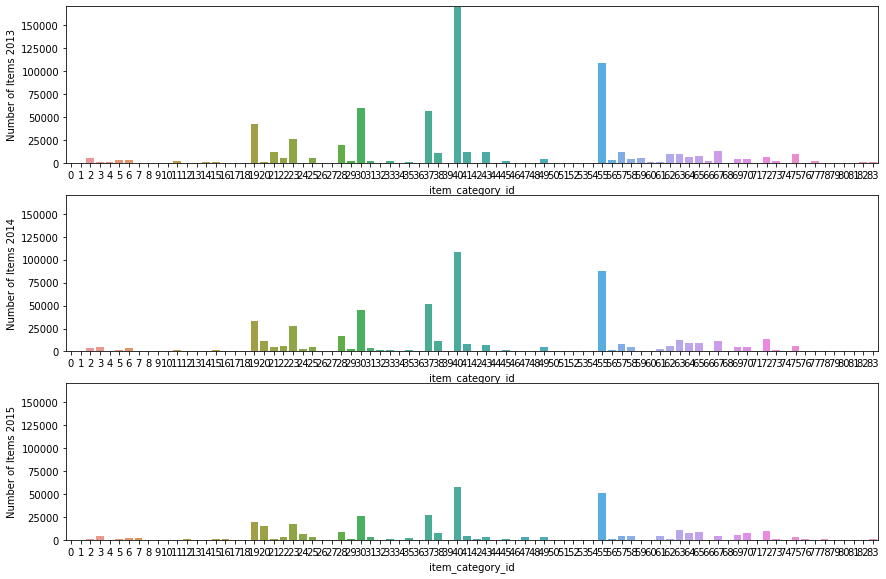

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="item_category_id", y="num_items", data=categories_year_2013, ax=ax[0])
ax[0].set_ylabel("Number of Items 2013")
ax[0].set(ylim=(0, train_number_items_df["num_items"].max() + 100))
sns.barplot(x="item_category_id", y="num_items", data=categories_year_2014, ax=ax[1])
ax[1].set_ylabel("Number of Items 2014")
ax[1].set(ylim=(0, train_number_items_df["num_items"].max() + 100))
sns.barplot(x="item_category_id", y="num_items", data=categories_year_2015, ax=ax[2])
ax[2].set_ylabel("Number of Items 2015")
ax[2].set(ylim=(0, train_number_items_df["num_items"].max() + 100))

# Shop Level 

## What Shop Sells More?

In [37]:
def fill_missing_shops(df: pd.DataFrame, all_shop_ids: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_shop_ids = set(df["shop_id"].unique())
    missing_shop_ids = all_shop_ids - df_shop_ids
    new_rows = []
    for missing_shop_id in missing_shop_ids:
        new_rows.append(
            (year, missing_shop_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "shop_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [38]:
train_shop_sales_df = train_monthly_df.groupby(["year", "shop_id"], as_index=False).agg({"item_cnt": ["sum"], "item_revenue": ["sum"]})
train_shop_sales_df.columns = ["year", "shop_id", "item_cnt", "item_revenue"]

shops_year_2013 = train_shop_sales_df[train_shop_sales_df["year"] == 2013]
shops_year_2014 = train_shop_sales_df[train_shop_sales_df["year"] == 2014]
shops_year_2015 = train_shop_sales_df[train_shop_sales_df["year"] == 2015]

all_possible_shop_ids = set(shops_year_2013["shop_id"].unique()).union(set(shops_year_2014["shop_id"].unique())).union(set(shops_year_2015["shop_id"].unique()))
shops_year_2013 = fill_missing_shops(shops_year_2013, all_possible_shop_ids)
shops_year_2014 = fill_missing_shops(shops_year_2014, all_possible_shop_ids)
shops_year_2015 = fill_missing_shops(shops_year_2015, all_possible_shop_ids)

[(0.0, 132587.0)]

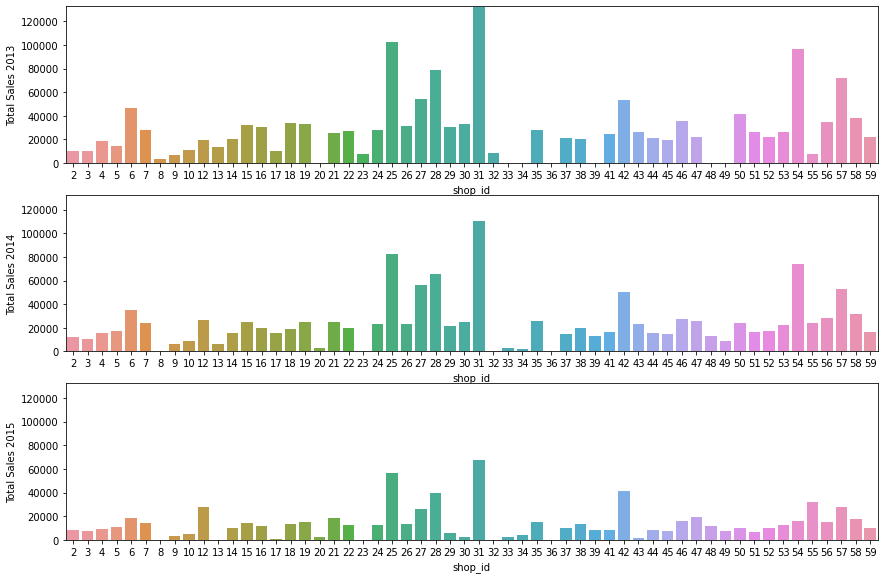

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2013, ax=ax[0])
ax[0].set_ylabel("Total Sales 2013")
ax[0].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))
sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2014, ax=ax[1])
ax[1].set_ylabel("Total Sales 2014")
ax[1].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))
sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2015, ax=ax[2])
ax[2].set_ylabel("Total Sales 2015")
ax[2].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))

## Decomposition

In [40]:
def decompose(df: pd.DataFrame, shop_id: int):
    """
        df: DataFrame with a daily frequency
    """
    
    df = df.copy()
    all_dates = df["date"]
    all_dates = pd.date_range(start=all_dates.min(), end=all_dates.max(), freq="1D")
    
    df = df[df["shop_id"] == shop_id]
    df = df.groupby(["date"]).sum()
    # Reindex the time series so our 1D frequency is consistent.
    df = df.reindex(all_dates)
    df = df.fillna(0)
    
    old_figsize = rcParams["figure.figsize"]
    rcParams["figure.figsize"] = 12, 10
    
    decomposition = sm.tsa.seasonal_decompose(df["item_cnt_day"])
    decomposition.plot()
    
    rcParams["figure.figsize"] = old_figsize

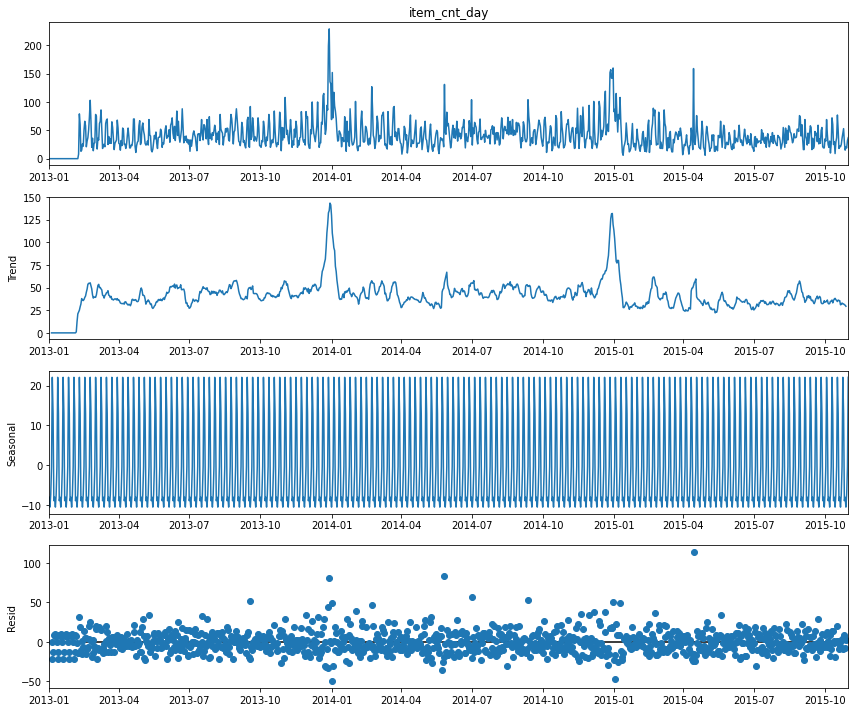

In [41]:
decompose(train_df, shop_id=5)

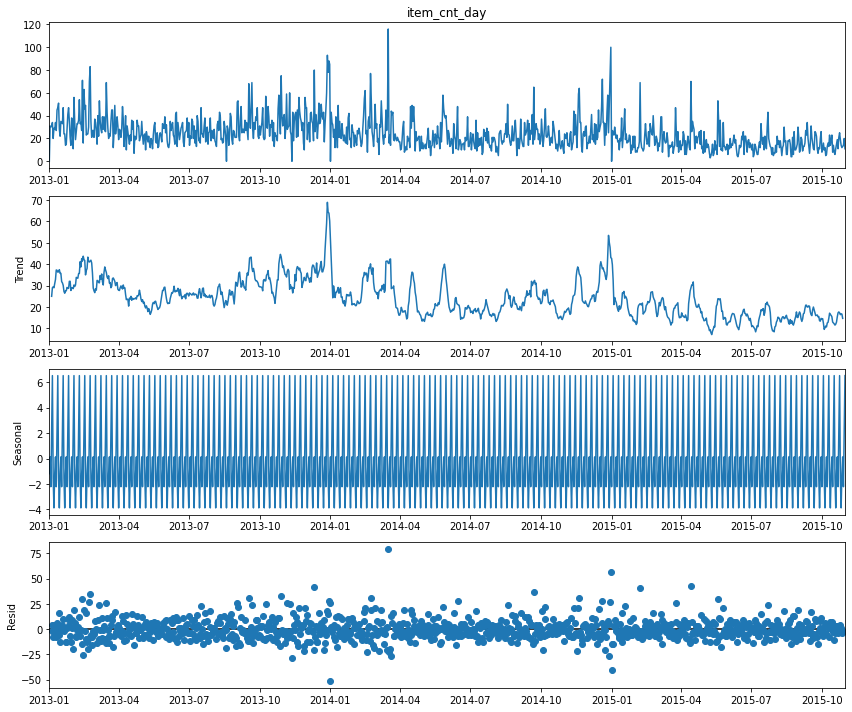

In [42]:
decompose(train_df, shop_id=10)

# Correlation

In [47]:
def correlation_matrix(df: pd.DataFrame, columns: List[str], shop_id: int):
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    
    df = df.copy()
    df = df[df["shop_id"] == shop_id]
    df = df.groupby("date").sum()
    df = df.sort_index()
    matrix = df[columns].corr(method="pearson")
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
    plt.show();

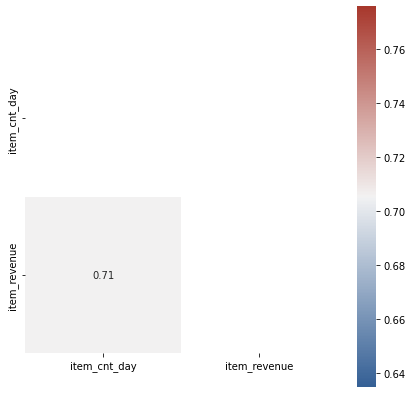

In [50]:
correlation_matrix(train_df, columns=["item_cnt_day", "item_revenue"], shop_id=5)

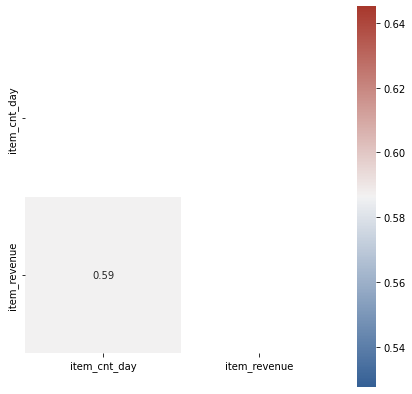

In [52]:
correlation_matrix(train_df, columns=["item_cnt_day", "item_revenue"], shop_id=10)

## Autocorrelation

In [78]:
def autocorrelation(df: pd.DataFrame, shop_id: int, month_lags: int = 6):
    df = df.copy()
    df = df[df["shop_id"] == shop_id]
    df = df.groupby("date").sum()
    df = df.sort_index()
    
    assert len(df) > 0
    
    fig, axes = plt.subplots(2,1,figsize=(12,10))
    sm.graphics.tsa.plot_acf(df["item_cnt_day"], lags=30*month_lags, ax=axes[0])
    axes[0].set_title(f"Daily Item Sales Autocorrelation for ~{month_lags} Months")
    sm.graphics.tsa.plot_acf(df["item_revenue"], lags=30*month_lags, ax=axes[1])
    axes[1].set_title(f"Daily Revenue Autocorrelation for ~{month_lags} Month")

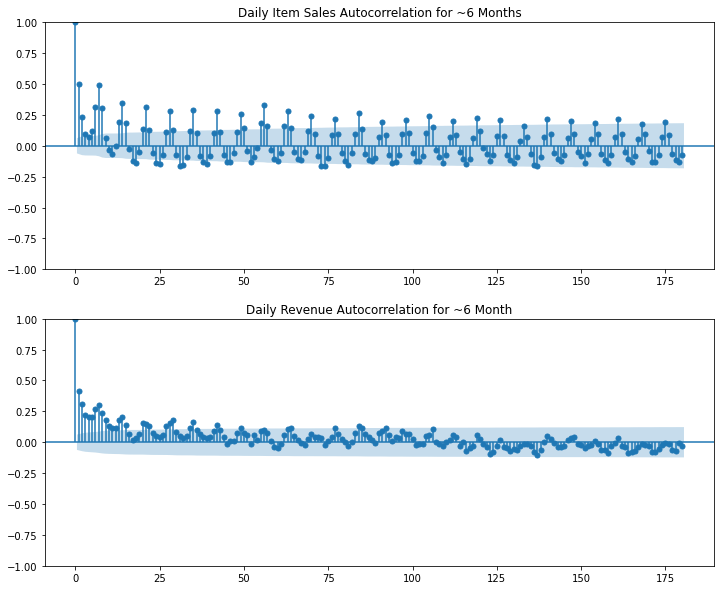

In [80]:
autocorrelation(train_df, shop_id=5)

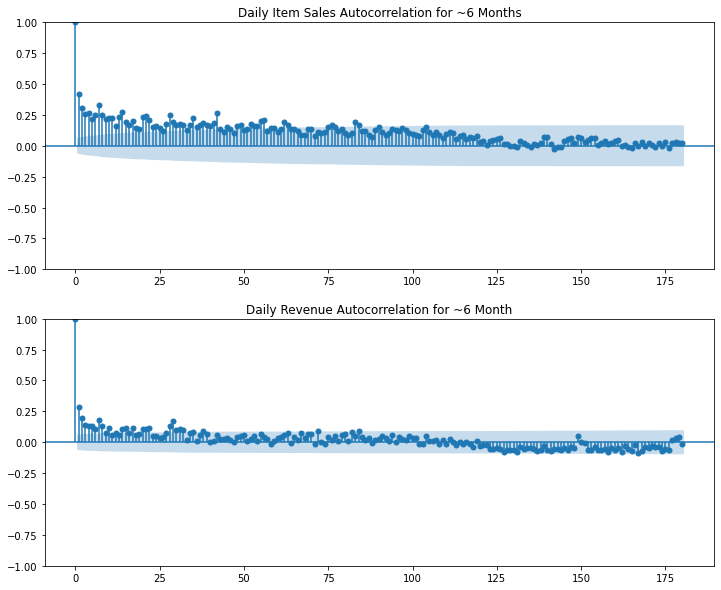

In [81]:
autocorrelation(train_df, shop_id=10)

# Item Level